## EECE5644 Assignment 2 - Question 2

**Note**: This solution uses the official data generation from `hw2q2.py`


#### Import necessary libraries for numerical computation, optimization, and visualization

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.linalg import inv
import pandas as pd
np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

#### Define function to compute cubic polynomial features from input vector x

In [11]:
def compute_cubic_features(X):
    n_samples = X.shape[0]
    x1 = X[:, 0]
    x2 = X[:, 1]
    Phi = np.column_stack([
        np.ones(n_samples),    # 1
        x1,                     # x1
        x2,                     # x2
        x1**2,                  # x1^2
        x1 * x2,                # x1*x2
        x2**2,                  # x2^2
        x1**3,                  # x1^3
        (x1**2) * x2,           # x1^2*x2
        x1 * (x2**2),           # x1*x2^2
        x2**3                   # x2^3
    ])
    return Phi
X_test = np.array([[1.0, 2.0], [0.5, -1.0]])
Phi_test = compute_cubic_features(X_test)
print("Feature computation test:")
print(f"Input shape: {X_test.shape}")
print(f"Output shape: {Phi_test.shape}")
print(f"\nExample features for x=[1.0, 2.0]:")
print(f"  {Phi_test[0]}")
print("Feature names: [1, x1, x2, x1^2, x1*x2, x2^2, x1^3, x1^2*x2, x1*x2^2, x2^3]")

Feature computation test:
Input shape: (2, 2)
Output shape: (2, 10)

Example features for x=[1.0, 2.0]:
  [1. 1. 2. 1. 2. 4. 1. 2. 4. 8.]
Feature names: [1, x1, x2, x1^2, x1*x2, x2^2, x1^3, x1^2*x2, x1*x2^2, x2^3]


#### Generate training and validation datasets

In [12]:
def generateData(N):
    """Official data generation function from hw2q2.py"""
    gmmParameters = {}
    gmmParameters['priors'] = [.3,.4,.3]
    gmmParameters['meanVectors'] = np.array([[-10, 0, 10], [0, 0, 0], [10, 0, -10]])
    gmmParameters['covMatrices'] = np.zeros((3, 3, 3))
    gmmParameters['covMatrices'][:,:,0] = np.array([[1, 0, -3], [0, 1, 0], [-3, 0, 15]])
    gmmParameters['covMatrices'][:,:,1] = np.array([[8, 0, 0], [0, .5, 0], [0, 0, .5]])
    gmmParameters['covMatrices'][:,:,2] = np.array([[1, 0, -3], [0, 1, 0], [-3, 0, 15]])
    x, labels = generateDataFromGMM(N, gmmParameters)
    return x

def generateDataFromGMM(N, gmmParameters):
    priors = gmmParameters['priors']
    meanVectors = gmmParameters['meanVectors']
    covMatrices = gmmParameters['covMatrices']
    n = meanVectors.shape[0]
    C = len(priors)
    x = np.zeros((n, N))
    labels = np.zeros((1, N))
    u = np.random.random((1, N))
    thresholds = np.zeros((1, C+1))
    thresholds[:,0:C] = np.cumsum(priors)
    thresholds[:,C] = 1
    for l in range(C):
        indl = np.where(u <= float(thresholds[:,l]))
        Nl = len(indl[1])
        labels[indl] = (l+1)*1
        u[indl] = 1.1
        x[:,indl[1]] = np.transpose(np.random.multivariate_normal(meanVectors[:,l], covMatrices[:,:,l], Nl))
    return x, labels

# Generate training data using official function
n_train = 100
n_validate = 1000

print(f"Training samples: {n_train}")
print(f"Validation samples: {n_validate}")

# Generate and parse training data
data_train = generateData(n_train)
X_train = data_train[0:2, :].T  
y_train = data_train[2, :]      

# Generate and parse validation data
data_validate = generateData(n_validate)
X_validate = data_validate[0:2, :].T  
y_validate = data_validate[2, :]       

print("\nData generated successfully using official GMM!")
print(f"\nTraining set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  y_train range: [{y_train.min():.3f}, {y_train.max():.3f}]")

print(f"\nValidation set:")
print(f"  X_validate shape: {X_validate.shape}")
print(f"  y_validate shape: {y_validate.shape}")
print(f"  y_validate range: [{y_validate.min():.3f}, {y_validate.max():.3f}]")

Training samples: 100
Validation samples: 1000

Data generated successfully using official GMM!

Training set:
  X_train shape: (100, 2)
  y_train shape: (100,)
  y_train range: [-15.695, 17.333]

Validation set:
  X_validate shape: (1000, 2)
  y_validate shape: (1000,)
  y_validate range: [-19.787, 20.190]


C:\Users\dawei\AppData\Local\Temp\ipykernel_110772\290421378.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  indl = np.where(u <= float(thresholds[:,l]))


#### Visualize the training data in 3D space

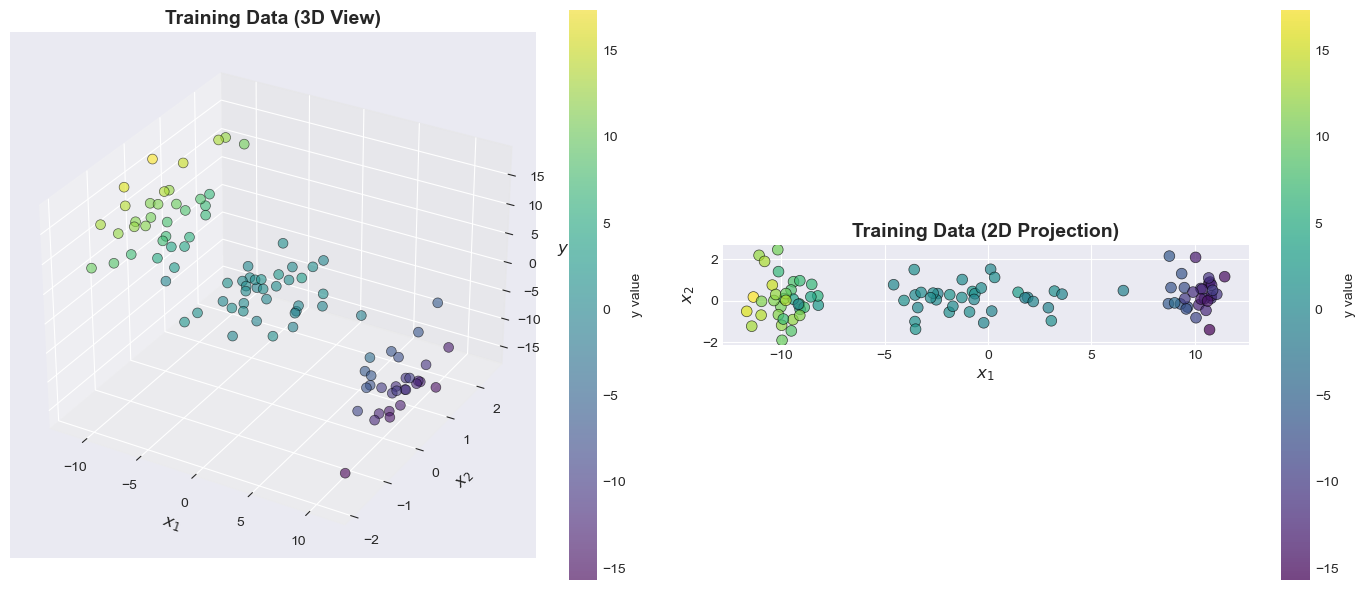

In [13]:
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121, projection='3d')
scatter = ax1.scatter(X_train[:, 0], X_train[:, 1], y_train, 
                     c=y_train, cmap='viridis', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
ax1.set_xlabel('$x_1$', fontsize=12)
ax1.set_ylabel('$x_2$', fontsize=12)
ax1.set_zlabel('$y$', fontsize=12)
ax1.set_title('Training Data (3D View)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=ax1, label='y value')
ax2 = fig.add_subplot(122)
scatter2 = ax2.scatter(X_train[:, 0], X_train[:, 1], 
                       c=y_train, cmap='viridis', s=60, alpha=0.7, edgecolors='k', linewidth=0.5)
ax2.set_xlabel('$x_1$', fontsize=12)
ax2.set_ylabel('$x_2$', fontsize=12)
ax2.set_title('Training Data (2D Projection)', fontsize=14, fontweight='bold')
ax2.set_aspect('equal')
plt.colorbar(scatter2, ax=ax2, label='y value')
plt.tight_layout()
plt.show()

#### Maximum Likelihood (ML) Estimation

#### Implement the Maximum Likelihood estimator using closed-form solution

In [14]:
def ml_estimator(X, y):
    Phi = compute_cubic_features(X)
    w_ml = np.linalg.lstsq(Phi, y, rcond=None)[0]
    return w_ml

#### Apply ML estimator to the training data

In [15]:
w_ml = ml_estimator(X_train, y_train)

print("Maximum Likelihood Estimation Results:")
print("="*70)
print("\nEstimated parameters (w_ML):")
for i, w_est in enumerate(w_ml):
    print(f"  w[{i}]: {w_est:10.4f}")

# Compute performance
Phi_train = compute_cubic_features(X_train)
y_train_pred_ml = Phi_train @ w_ml
train_mse_ml = np.mean((y_train - y_train_pred_ml)**2)

Phi_validate = compute_cubic_features(X_validate)
y_validate_pred_ml = Phi_validate @ w_ml
validate_mse_ml = np.mean((y_validate - y_validate_pred_ml)**2)

print(f"\nPerformance:")
print(f"  Training MSE:   {train_mse_ml:.6f}")
print(f"  Validation MSE: {validate_mse_ml:.6f}")
print("="*70)

Maximum Likelihood Estimation Results:

Estimated parameters (w_ML):
  w[0]:     0.3217
  w[1]:     0.1559
  w[2]:     0.0580
  w[3]:    -0.0035
  w[4]:     0.0417
  w[5]:    -0.1980
  w[6]:    -0.0111
  w[7]:     0.0026
  w[8]:    -0.0345
  w[9]:    -0.0703

Performance:
  Training MSE:   3.224257
  Validation MSE: 4.886205


#### Maximum A Posteriori (MAP) Estimation

#### Implement the MAP estimator with Gaussian prior

In [16]:
def map_estimator(X, y, gamma, sigma_sq=None):
    Phi = compute_cubic_features(X)
    n_features = Phi.shape[1]
    if sigma_sq is None:
        w_ml_temp = np.linalg.lstsq(Phi, y, rcond=None)[0]
        residuals = y - Phi @ w_ml_temp
        sigma_sq = np.mean(residuals**2)
    lambda_reg = sigma_sq / gamma
    A = Phi.T @ Phi + lambda_reg * np.eye(n_features)
    b = Phi.T @ y
    w_map = np.linalg.solve(A, b)
    return w_map

#### Test MAP estimator with a single gamma value

In [17]:
gamma_test = 1.0
w_map_test = map_estimator(X_train, y_train, gamma_test)

print(f"MAP Estimation Test (γ = {gamma_test}):")
print("="*70)
print("\nEstimated parameters (w_MAP):")
for i, (w_map, w_ml_val) in enumerate(zip(w_map_test, w_ml)):
    print(f"  w[{i}]: {w_map:10.4f}  (ML: {w_ml_val:10.4f})")

y_validate_pred_map = Phi_validate @ w_map_test
validate_mse_map = np.mean((y_validate - y_validate_pred_map)**2)

print(f"\nValidation MSE (MAP): {validate_mse_map:.6f}")
print(f"Validation MSE (ML):  {validate_mse_ml:.6f}")
print("="*70)

MAP Estimation Test (γ = 1.0):

Estimated parameters (w_MAP):
  w[0]:     0.2841  (ML:     0.3217)
  w[1]:     0.1518  (ML:     0.1559)
  w[2]:     0.0542  (ML:     0.0580)
  w[3]:    -0.0032  (ML:    -0.0035)
  w[4]:     0.0408  (ML:     0.0417)
  w[5]:    -0.1818  (ML:    -0.1980)
  w[6]:    -0.0111  (ML:    -0.0111)
  w[7]:     0.0026  (ML:     0.0026)
  w[8]:    -0.0338  (ML:    -0.0345)
  w[9]:    -0.0737  (ML:    -0.0703)

Validation MSE (MAP): 4.847212
Validation MSE (ML):  4.886205


#### Systematically evaluate MAP estimator for a range of gamma values

In [18]:
gamma_values = np.logspace(-6, 6, 50)  # From 10^-6 to 10^6
train_mse_map = []
validate_mse_map = []
w_map_all = []
w_norms = []
print(f"Evaluating MAP estimator for {len(gamma_values)} gamma values...")
print(f"Gamma range: [{gamma_values.min():.2e}, {gamma_values.max():.2e}]")
for gamma in gamma_values:
    w_map = map_estimator(X_train, y_train, gamma)
    w_map_all.append(w_map)
    w_norms.append(np.linalg.norm(w_map))
    y_train_pred = Phi_train @ w_map
    train_mse = np.mean((y_train - y_train_pred)**2)
    train_mse_map.append(train_mse)
    y_validate_pred = Phi_validate @ w_map
    validate_mse = np.mean((y_validate - y_validate_pred)**2)
    validate_mse_map.append(validate_mse)
train_mse_map = np.array(train_mse_map)
validate_mse_map = np.array(validate_mse_map)
w_norms = np.array(w_norms)
best_idx = np.argmin(validate_mse_map)
gamma_optimal = gamma_values[best_idx]
w_map_optimal = w_map_all[best_idx]
validate_mse_optimal = validate_mse_map[best_idx]
print(f"\nOptimal γ: {gamma_optimal:.4e}")
print(f"Minimum validation MSE: {validate_mse_optimal:.6f}")
print(f"ML validation MSE: {validate_mse_ml:.6f}")
print(f"\nImprovement over ML: {((validate_mse_ml - validate_mse_optimal)/validate_mse_ml * 100):.2f}%")

Evaluating MAP estimator for 50 gamma values...
Gamma range: [1.00e-06, 1.00e+06]

Optimal γ: 5.4287e-06
Minimum validation MSE: 4.268458
ML validation MSE: 4.886205

Improvement over ML: 12.64%


#### Visualize validation MSE as a function of gamma

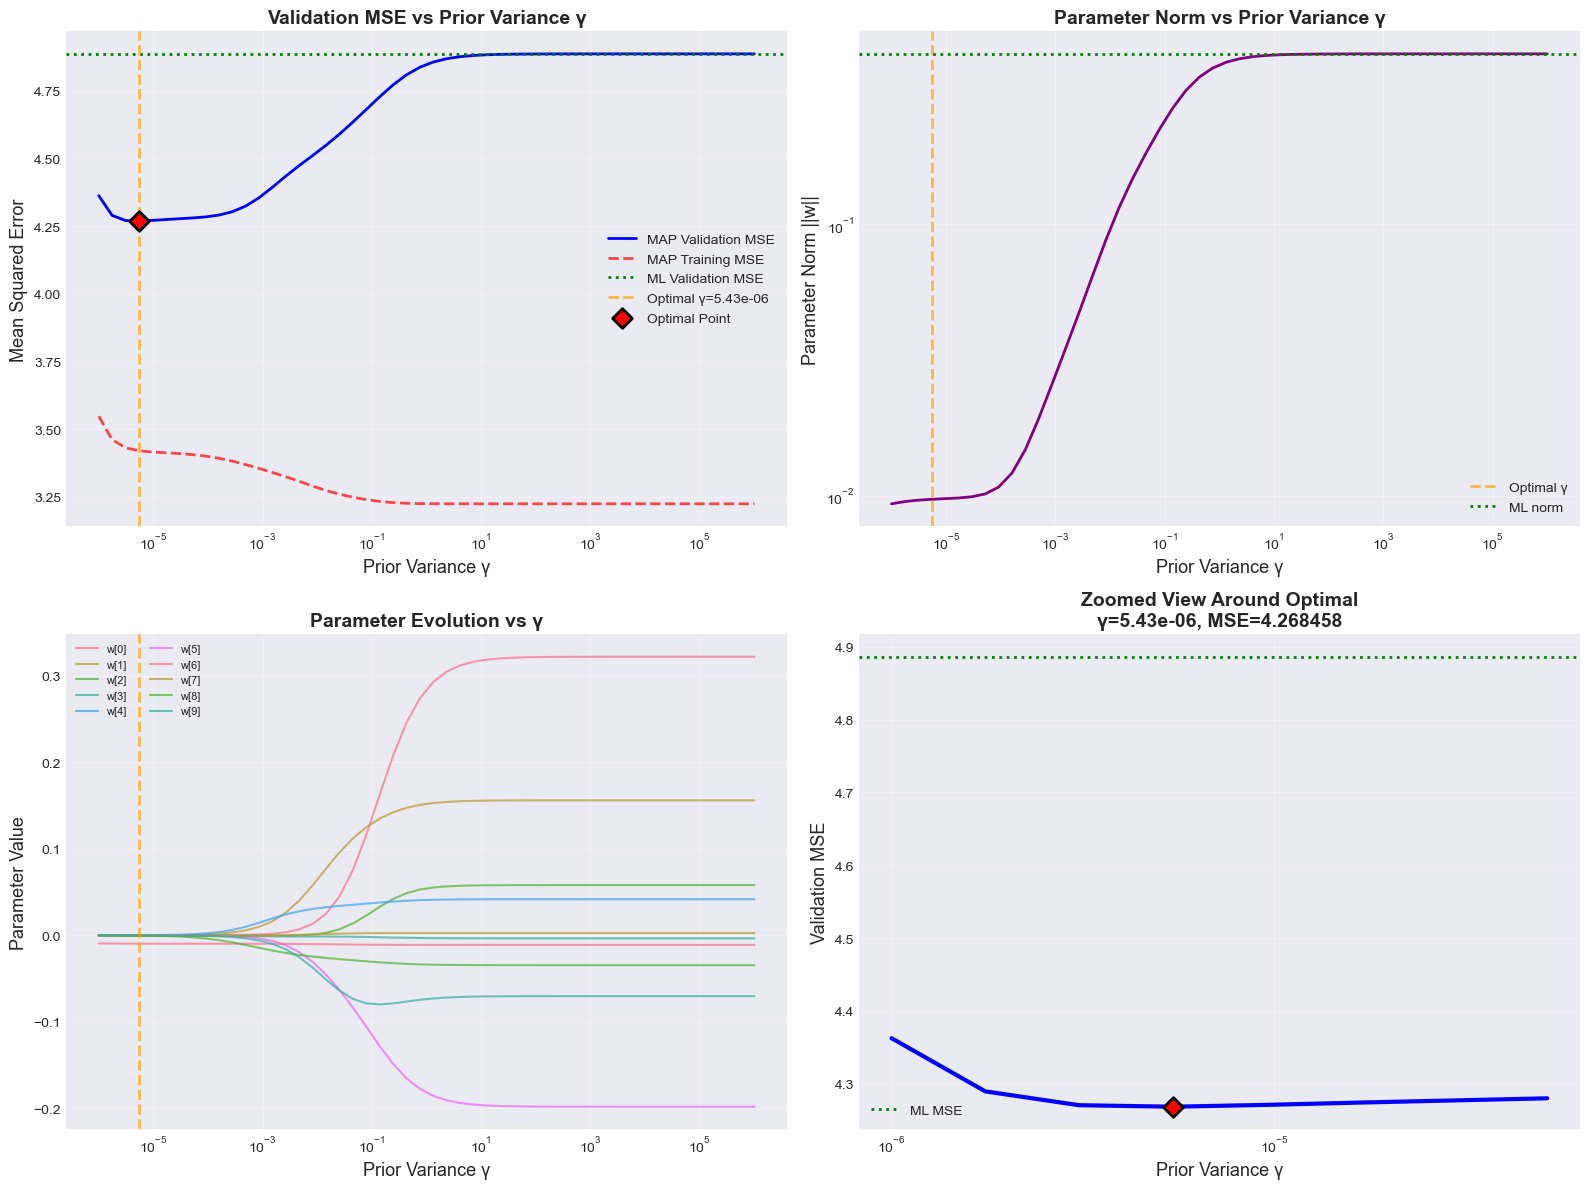

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
ax1 = axes[0, 0]
ax1.semilogx(gamma_values, validate_mse_map, 'b-', linewidth=2, label='MAP Validation MSE')
ax1.semilogx(gamma_values, train_mse_map, 'r--', linewidth=2, alpha=0.7, label='MAP Training MSE')
ax1.axhline(y=validate_mse_ml, color='green', linestyle=':', linewidth=2, label='ML Validation MSE')
ax1.axvline(x=gamma_optimal, color='orange', linestyle='--', linewidth=2, alpha=0.7, label=f'Optimal γ={gamma_optimal:.2e}')
ax1.scatter([gamma_optimal], [validate_mse_optimal], color='red', s=100, zorder=5, 
           marker='D', edgecolors='black', linewidth=2, label='Optimal Point')
ax1.set_xlabel('Prior Variance γ', fontsize=13)
ax1.set_ylabel('Mean Squared Error', fontsize=13)
ax1.set_title('Validation MSE vs Prior Variance γ', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax2 = axes[0, 1]
ax2.loglog(gamma_values, w_norms, 'purple', linewidth=2)
ax2.axvline(x=gamma_optimal, color='orange', linestyle='--', linewidth=2, alpha=0.7, label=f'Optimal γ')
ax2.axhline(y=np.linalg.norm(w_ml), color='green', linestyle=':', linewidth=2, label='ML norm')
ax2.set_xlabel('Prior Variance γ', fontsize=13)
ax2.set_ylabel('Parameter Norm ||w||', fontsize=13)
ax2.set_title('Parameter Norm vs Prior Variance γ', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax3 = axes[1, 0]
w_map_array = np.array(w_map_all)
for i in range(w_map_array.shape[1]):
    ax3.semilogx(gamma_values, w_map_array[:, i], linewidth=1.5, alpha=0.7, label=f'w[{i}]')
ax3.axvline(x=gamma_optimal, color='orange', linestyle='--', linewidth=2, alpha=0.7)
ax3.set_xlabel('Prior Variance γ', fontsize=13)
ax3.set_ylabel('Parameter Value', fontsize=13)
ax3.set_title('Parameter Evolution vs γ', fontsize=14, fontweight='bold')
ax3.legend(fontsize=8, ncol=2)
ax3.grid(True, alpha=0.3)
ax4 = axes[1, 1]
zoom_range = (gamma_values > gamma_optimal/10) & (gamma_values < gamma_optimal*10)
ax4.semilogx(gamma_values[zoom_range], validate_mse_map[zoom_range], 'b-', linewidth=3)
ax4.scatter([gamma_optimal], [validate_mse_optimal], color='red', s=100, zorder=5, 
           marker='D', edgecolors='black', linewidth=2)
ax4.axhline(y=validate_mse_ml, color='green', linestyle=':', linewidth=2, label='ML MSE')
ax4.set_xlabel('Prior Variance γ', fontsize=13)
ax4.set_ylabel('Validation MSE', fontsize=13)
ax4.set_title(f'Zoomed View Around Optimal\nγ={gamma_optimal:.2e}, MSE={validate_mse_optimal:.6f}', 
             fontsize=14, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Compare ML and optimal MAP predictions visually

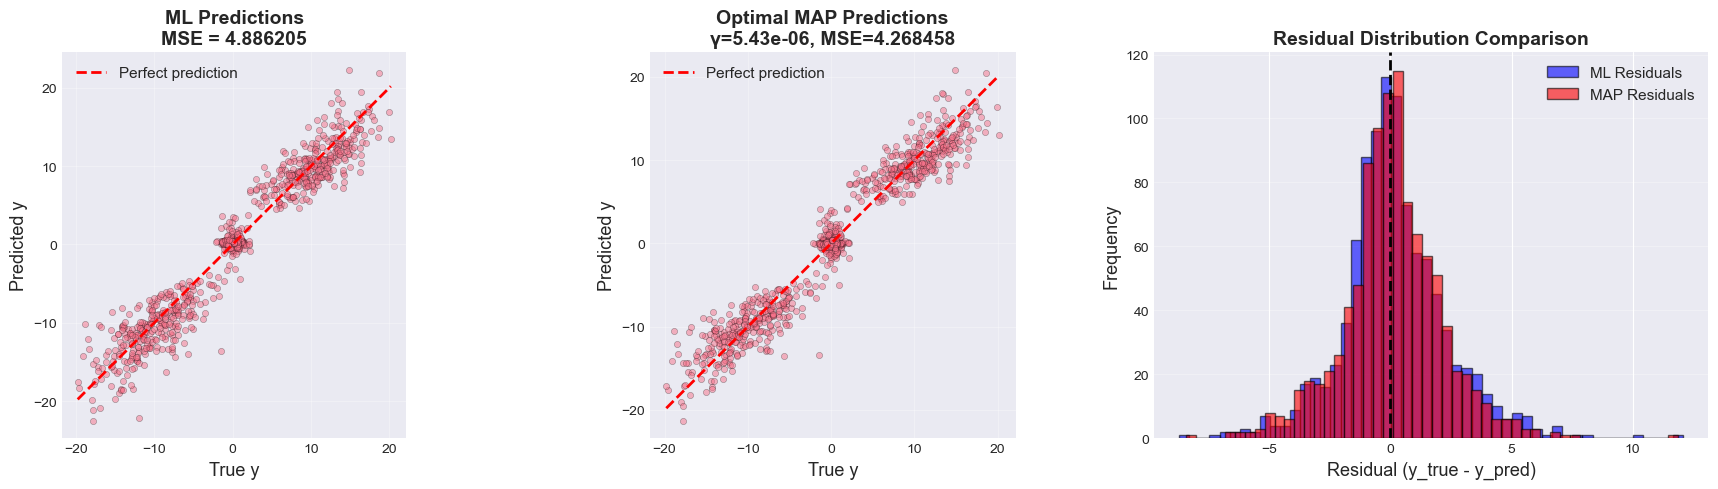

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
ax1 = axes[0]
ax1.scatter(y_validate, y_validate_pred_ml, alpha=0.5, s=20, edgecolors='k', linewidth=0.3)
ax1.plot([y_validate.min(), y_validate.max()], [y_validate.min(), y_validate.max()], 
        'r--', linewidth=2, label='Perfect prediction')
ax1.set_xlabel('True y', fontsize=13)
ax1.set_ylabel('Predicted y', fontsize=13)
ax1.set_title(f'ML Predictions\nMSE = {validate_mse_ml:.6f}', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal')
ax2 = axes[1]
y_validate_pred_map_opt = Phi_validate @ w_map_optimal
ax2.scatter(y_validate, y_validate_pred_map_opt, alpha=0.5, s=20, edgecolors='k', linewidth=0.3)
ax2.plot([y_validate.min(), y_validate.max()], [y_validate.min(), y_validate.max()], 
        'r--', linewidth=2, label='Perfect prediction')
ax2.set_xlabel('True y', fontsize=13)
ax2.set_ylabel('Predicted y', fontsize=13)
ax2.set_title(f'Optimal MAP Predictions\nγ={gamma_optimal:.2e}, MSE={validate_mse_optimal:.6f}', 
             fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal')
ax3 = axes[2]
residuals_ml = y_validate - y_validate_pred_ml
residuals_map = y_validate - y_validate_pred_map_opt
ax3.hist(residuals_ml, bins=50, alpha=0.6, label='ML Residuals', color='blue', edgecolor='black')
ax3.hist(residuals_map, bins=50, alpha=0.6, label='MAP Residuals', color='red', edgecolor='black')
ax3.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax3.set_xlabel('Residual (y_true - y_pred)', fontsize=13)
ax3.set_ylabel('Frequency', fontsize=13)
ax3.set_title('Residual Distribution Comparison', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

#### Compare parameter estimates: ML vs MAP vs True

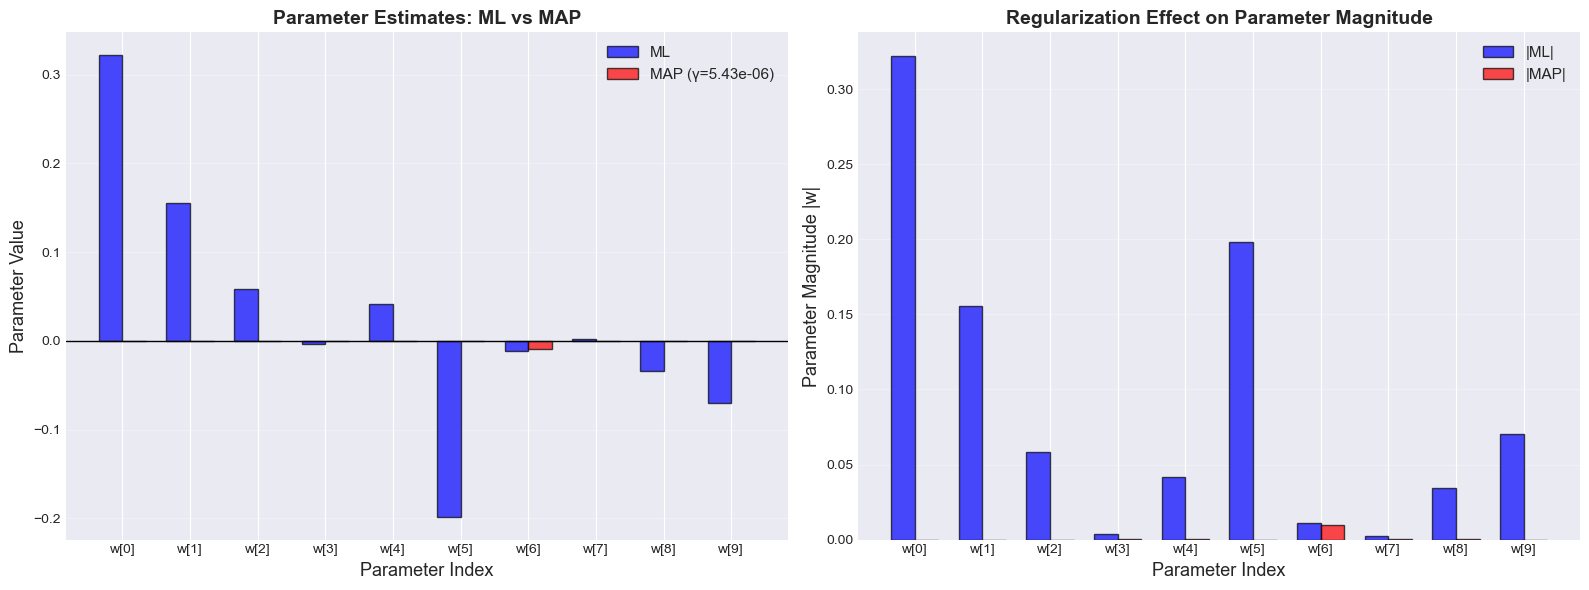


Parameter Statistics:
L2 Norm (ML):  0.422368
L2 Norm (MAP): 0.009683
Regularization reduced norm by: 97.71%


In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Parameter values comparison (ML vs MAP only)
ax1 = axes[0]
x_pos = np.arange(len(w_ml))
width = 0.35

ax1.bar(x_pos - width/2, w_ml, width, label='ML', color='blue', alpha=0.7, edgecolor='black')
ax1.bar(x_pos + width/2, w_map_optimal, width, label=f'MAP (γ={gamma_optimal:.2e})', 
       color='red', alpha=0.7, edgecolor='black')

ax1.set_xlabel('Parameter Index', fontsize=13)
ax1.set_ylabel('Parameter Value', fontsize=13)
ax1.set_title('Parameter Estimates: ML vs MAP', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f'w[{i}]' for i in range(len(w_ml))])
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(y=0, color='black', linewidth=1)

# Plot 2: Parameter magnitudes (shows regularization effect)
ax2 = axes[1]
ml_mag = np.abs(w_ml)
map_mag = np.abs(w_map_optimal)

ax2.bar(x_pos - width/2, ml_mag, width, label='|ML|', color='blue', alpha=0.7, edgecolor='black')
ax2.bar(x_pos + width/2, map_mag, width, label='|MAP|', color='red', alpha=0.7, edgecolor='black')

ax2.set_xlabel('Parameter Index', fontsize=13)
ax2.set_ylabel('Parameter Magnitude |w|', fontsize=13)
ax2.set_title('Regularization Effect on Parameter Magnitude', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'w[{i}]' for i in range(len(w_ml))])
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('q2_parameters_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nParameter Statistics:")
print("="*70)
print(f"L2 Norm (ML):  {np.linalg.norm(w_ml):.6f}")
print(f"L2 Norm (MAP): {np.linalg.norm(w_map_optimal):.6f}")
print(f"Regularization reduced norm by: {((np.linalg.norm(w_ml) - np.linalg.norm(w_map_optimal))/np.linalg.norm(w_ml)*100):.2f}%")
print("="*70)

#### FIGURE : Validation MSE as a Function of Hyperparameter γ

Computing MSE for different gamma values...


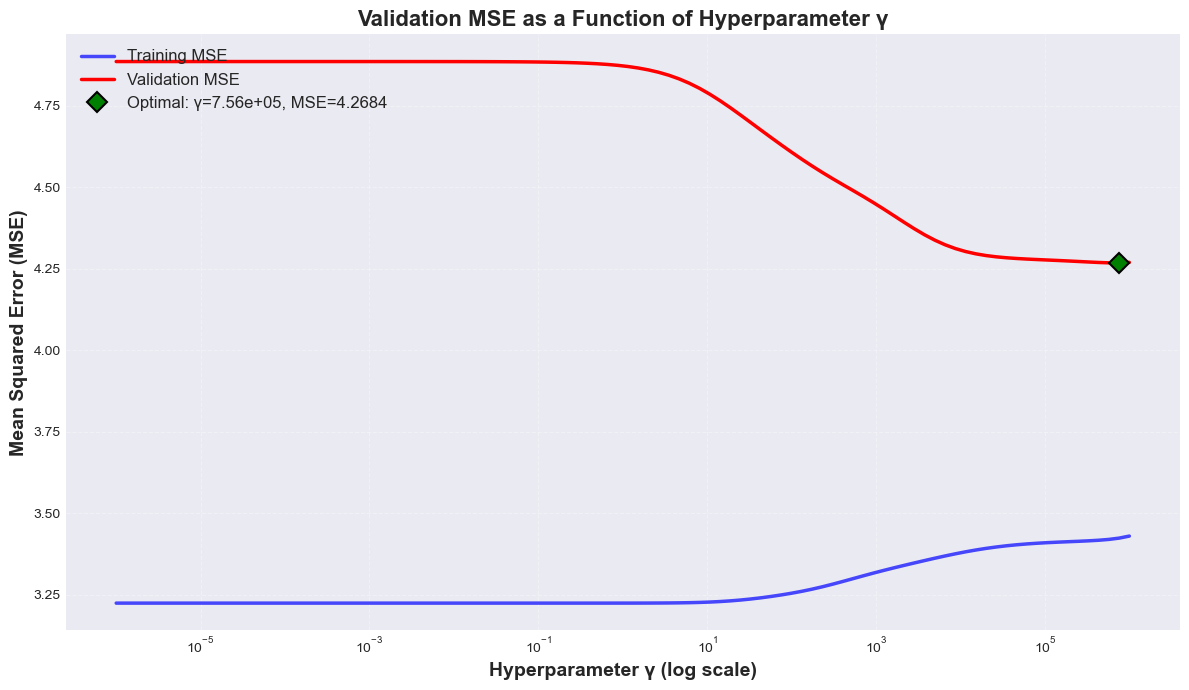


Optimal gamma from plot: 7.564633e+05
Optimal validation MSE: 4.268363
Training MSE at optimal gamma: 3.423720


In [22]:
gamma_range = np.logspace(-6, 6, 100)
train_mse_list = []
validate_mse_list = []

print("Computing MSE for different gamma values...")
for gamma in gamma_range:
    # MAP estimation with current gamma
    I = np.eye(Phi_train.shape[1])
    w_map = inv(Phi_train.T @ Phi_train + gamma * I) @ Phi_train.T @ y_train
    
    # Compute MSE on training and validation sets
    train_pred = Phi_train @ w_map
    validate_pred = Phi_validate @ w_map
    
    train_mse = np.mean((y_train - train_pred)**2)
    validate_mse = np.mean((y_validate - validate_pred)**2)
    
    train_mse_list.append(train_mse)
    validate_mse_list.append(validate_mse)

# Find optimal gamma
optimal_idx = np.argmin(validate_mse_list)
gamma_optimal_plot = gamma_range[optimal_idx]
mse_optimal_plot = validate_mse_list[optimal_idx]

# Plotting
plt.figure(figsize=(12, 7))
plt.semilogx(gamma_range, train_mse_list, 'b-', linewidth=2.5, label='Training MSE', alpha=0.7)
plt.semilogx(gamma_range, validate_mse_list, 'r-', linewidth=2.5, label='Validation MSE')
plt.semilogx(gamma_optimal_plot, mse_optimal_plot, 'gD', markersize=10, 
             markeredgecolor='black', markeredgewidth=1.5,
             label=f'Optimal: γ={gamma_optimal_plot:.2e}, MSE={mse_optimal_plot:.4f}')

plt.xlabel('Hyperparameter γ (log scale)', fontsize=14, fontweight='bold')
plt.ylabel('Mean Squared Error (MSE)', fontsize=14, fontweight='bold')
plt.title('Validation MSE as a Function of Hyperparameter γ', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3, which='both', linestyle='--')
plt.tight_layout()
plt.show()

print(f"\nOptimal gamma from plot: {gamma_optimal_plot:.6e}")
print(f"Optimal validation MSE: {mse_optimal_plot:.6f}")
print(f"Training MSE at optimal gamma: {train_mse_list[optimal_idx]:.6f}")

#### FIGURE: Parameter Magnitude vs γ

Computing parameter magnitudes for different gamma values...


C:\Users\dawei\AppData\Local\Temp\ipykernel_110772\4015378088.py:48: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.tight_layout()
C:\Users\dawei\AppData\Local\Temp\ipykernel_110772\4015378088.py:49: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.savefig('q2_param_magnitude.png', dpi=300, bbox_inches='tight')
C:\Users\dawei\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


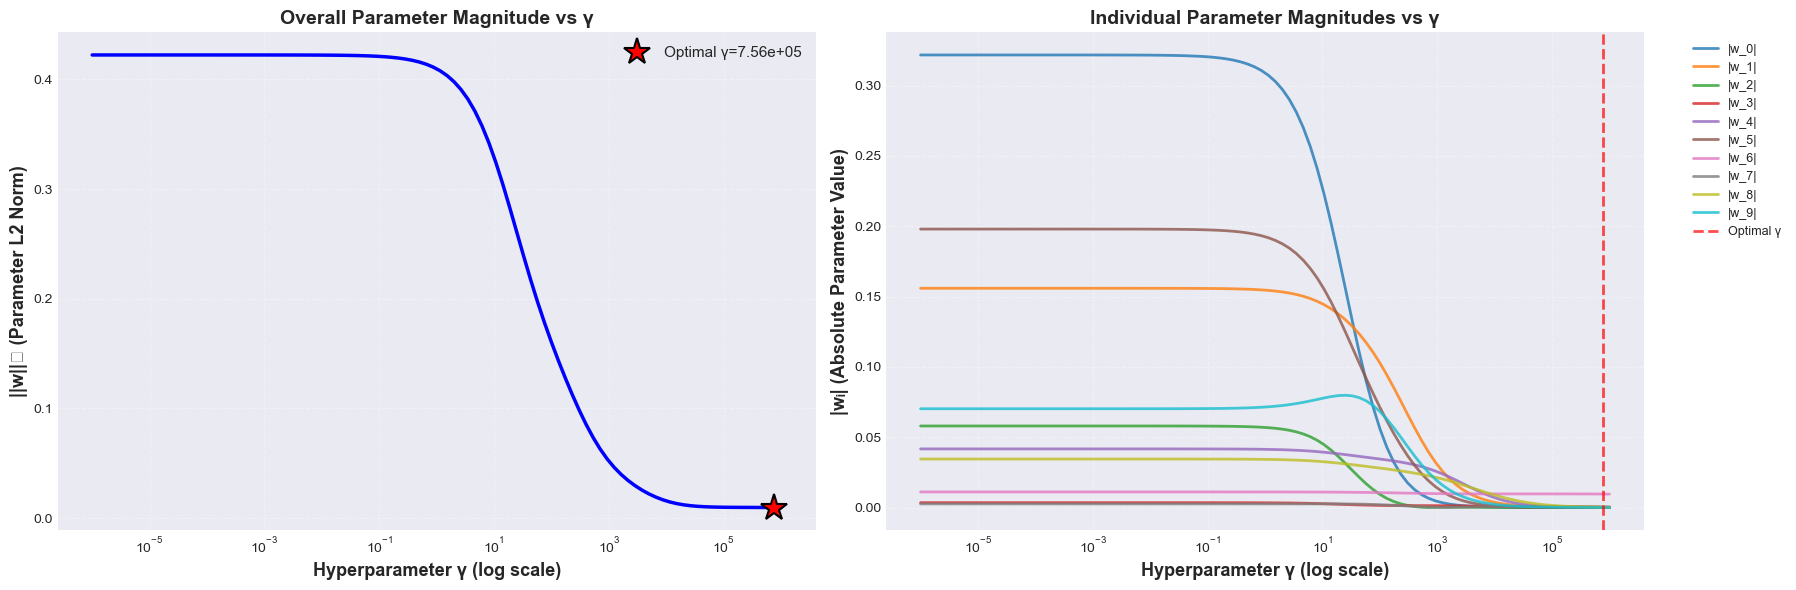


Parameter norm at optimal gamma: 0.009656
Parameter norm at γ=1e-6: 0.422368
Parameter norm at γ=1e6: 0.009619


In [ ]:
# Compute parameter norms for different gamma values
param_norms = []
param_vectors = []  # Store all parameter vectors for detailed analysis

print("Computing parameter magnitudes for different gamma values...")
for gamma in gamma_range:
    I = np.eye(Phi_train.shape[1])
    w_map = inv(Phi_train.T @ Phi_train + gamma * I) @ Phi_train.T @ y_train
    
    param_norm = np.linalg.norm(w_map)
    param_norms.append(param_norm)
    param_vectors.append(w_map)

param_vectors = np.array(param_vectors)  # Shape: (n_gamma, n_params)

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Subplot 1: Overall parameter norm (L2 norm)
ax1 = axes[0]
ax1.semilogx(gamma_range, param_norms, 'b-', linewidth=2.5)
ax1.semilogx(gamma_optimal_plot, param_norms[optimal_idx], 'r*', 
             markersize=20, markeredgecolor='black', markeredgewidth=1.5,
             label=f'Optimal γ={gamma_optimal_plot:.2e}')
ax1.set_xlabel('Hyperparameter γ (log scale)', fontsize=13, fontweight='bold')
ax1.set_ylabel('||w||₂ (Parameter L2 Norm)', fontsize=13, fontweight='bold')
ax1.set_title('Overall Parameter Magnitude vs γ', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, which='both', linestyle='--')
ax1.legend(fontsize=11)

# Subplot 2: Individual parameter trajectories
ax2 = axes[1]
n_params = param_vectors.shape[1]
colors = plt.cm.tab10(np.linspace(0, 1, n_params))

for i in range(n_params):
    ax2.semilogx(gamma_range, np.abs(param_vectors[:, i]), 
                 linewidth=2, alpha=0.8, label=f'|w_{i}|', color=colors[i])

ax2.axvline(gamma_optimal_plot, color='red', linestyle='--', linewidth=2, 
            alpha=0.7, label=f'Optimal γ')
ax2.set_xlabel('Hyperparameter γ (log scale)', fontsize=13, fontweight='bold')
ax2.set_ylabel('|wᵢ| (Absolute Parameter Value)', fontsize=13, fontweight='bold')
ax2.set_title('Individual Parameter Magnitudes vs γ', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both', linestyle='--')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=1)

plt.tight_layout()

plt.show()

print(f"\nParameter norm at optimal gamma: {param_norms[optimal_idx]:.6f}")
print(f"Parameter norm at γ=1e-6: {param_norms[0]:.6f}")
print(f"Parameter norm at γ=1e6: {param_norms[-1]:.6f}")

#### FIGURE 3: Model Comparison - ML vs Optimal MAP vs Over-regularized MAP

Computing predictions on grid for 3D surface plots...


C:\Users\dawei\AppData\Local\Temp\ipykernel_110772\1966966802.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions[i, j] = phi @ w
C:\Users\dawei\AppData\Local\Temp\ipykernel_110772\1966966802.py:55: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.tight_layout()


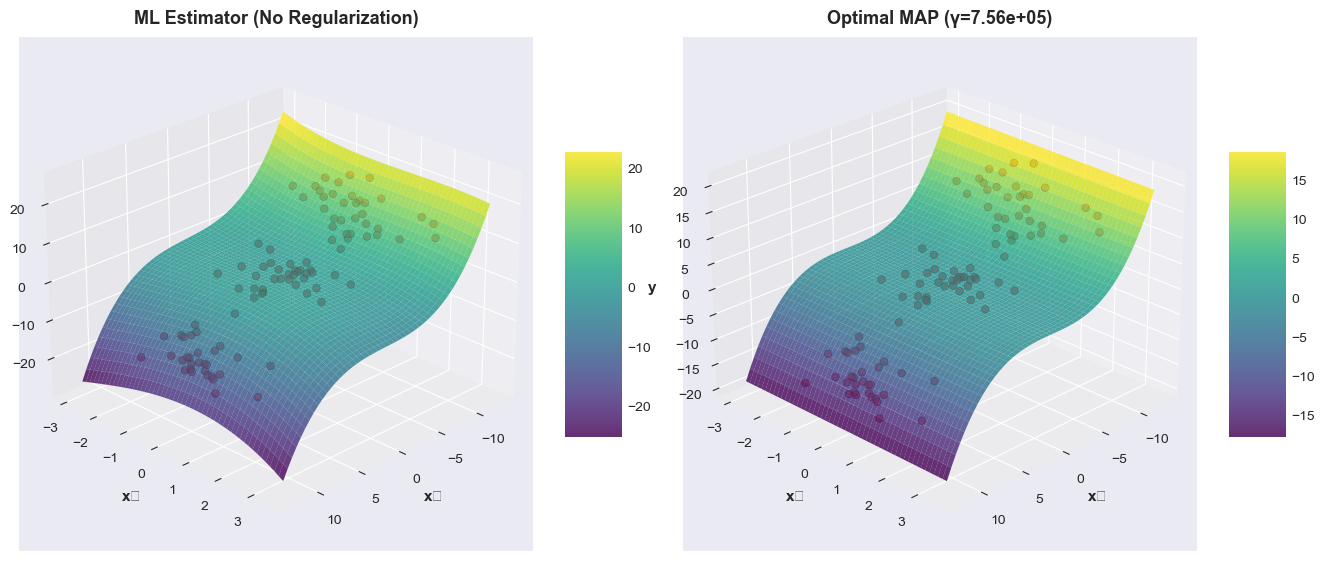


MODEL COMPARISON STATISTICS
ML Model:
  Validation MSE: 4.886205
  Parameter Norm: 0.422368

Optimal MAP Model (γ=7.56e+05):
  Validation MSE: 4.268363
  Parameter Norm: 0.009656


In [25]:
# Get three models
w_ml_plot = w_ml
w_map_optimal_plot = inv(Phi_train.T @ Phi_train + gamma_optimal_plot * np.eye(Phi_train.shape[1])) @ Phi_train.T @ y_train
gamma_over = gamma_optimal_plot * 1000  # Over-regularized
w_map_over = inv(Phi_train.T @ Phi_train + gamma_over * np.eye(Phi_train.shape[1])) @ Phi_train.T @ y_train

# Create grid for evaluation
x1_range = np.linspace(X_train[:, 0].min() - 1, X_train[:, 0].max() + 1, 50)
x2_range = np.linspace(X_train[:, 1].min() - 1, X_train[:, 1].max() + 1, 50)
X1_grid, X2_grid = np.meshgrid(x1_range, x2_range)

# Function to predict on grid
def predict_on_grid(w, X1_grid, X2_grid):
    predictions = np.zeros_like(X1_grid)
    for i in range(X1_grid.shape[0]):
        for j in range(X1_grid.shape[1]):
            x = np.array([[X1_grid[i, j], X2_grid[i, j]]])
            phi = compute_cubic_features(x)
            predictions[i, j] = phi @ w
    return predictions

print("Computing predictions on grid for 3D surface plots...")
Y_ML = predict_on_grid(w_ml_plot, X1_grid, X2_grid)
Y_MAP_optimal = predict_on_grid(w_map_optimal_plot, X1_grid, X2_grid)
Y_MAP_over = predict_on_grid(w_map_over, X1_grid, X2_grid)

# Create 3D surface plots
fig = plt.figure(figsize=(20, 6))

# ML Model
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(X1_grid, X2_grid, Y_ML, cmap='viridis', alpha=0.8, edgecolor='none')
ax1.scatter(X_train[:, 0], X_train[:, 1], y_train, c='red', marker='o', s=30, 
            alpha=0.6, edgecolors='black', linewidth=0.5, label='Training Data')
ax1.set_xlabel('x₁', fontsize=11, fontweight='bold')
ax1.set_ylabel('x₂', fontsize=11, fontweight='bold')
ax1.set_zlabel('y', fontsize=11, fontweight='bold')
ax1.set_title('ML Estimator (No Regularization)', fontsize=13, fontweight='bold', pad=10)
ax1.view_init(elev=25, azim=45)
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

# Optimal MAP Model
ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(X1_grid, X2_grid, Y_MAP_optimal, cmap='viridis', alpha=0.8, edgecolor='none')
ax2.scatter(X_train[:, 0], X_train[:, 1], y_train, c='red', marker='o', s=30,
            alpha=0.6, edgecolors='black', linewidth=0.5)
ax2.set_xlabel('x₁', fontsize=11, fontweight='bold')
ax2.set_ylabel('x₂', fontsize=11, fontweight='bold')
ax2.set_zlabel('y', fontsize=11, fontweight='bold')
ax2.set_title(f'Optimal MAP (γ={gamma_optimal_plot:.2e})', fontsize=13, fontweight='bold', pad=10)
ax2.view_init(elev=25, azim=45)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)


plt.tight_layout()
plt.show()

# Print comparison statistics
print("\n" + "="*80)
print("MODEL COMPARISON STATISTICS")
print("="*80)

mse_ml_val = np.mean((y_validate - Phi_validate @ w_ml_plot)**2)
mse_map_opt_val = np.mean((y_validate - Phi_validate @ w_map_optimal_plot)**2)
mse_map_over_val = np.mean((y_validate - Phi_validate @ w_map_over)**2)

print(f"ML Model:")
print(f"  Validation MSE: {mse_ml_val:.6f}")
print(f"  Parameter Norm: {np.linalg.norm(w_ml_plot):.6f}")
print(f"\nOptimal MAP Model (γ={gamma_optimal_plot:.2e}):")
print(f"  Validation MSE: {mse_map_opt_val:.6f}")
print(f"  Parameter Norm: {np.linalg.norm(w_map_optimal_plot):.6f}")
print("="*80)
